In [1]:
import sys
import os

# 添加 factor_evaluation.pyd 所在的目录到系统路径
pyd_path = r"D:\MG\！internship\！4L CAPITAL\因子评估器"
sys.path.append(pyd_path)

# 导入模块
from factor_evaluation import FactorEvaluation
from factor_evaluation import DataService
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

In [4]:
def adaptive_kdj_factor_v3(df, volatility_window=20):
    """
    使用Pandas TA完全重构的自适应KDJ因子
    结合波动率调整和EMA平滑
    """
    # 1. 计算波动率调整的周期长度
    returns = np.log(df['close']).diff()
    vol = returns.rolling(volatility_window, min_periods=1).std()
    vol = vol.replace([np.inf, -np.inf], np.nan).ffill().bfill().fillna(0.01)
    
    # 非线性缩放波动率
    scaled_vol = (vol * 100).clip(5, 20)
    n_period = np.where(
        scaled_vol > 15, 
        scaled_vol * 1.4, 
        scaled_vol * 0.6
    ).clip(5, 25).astype(int)
    
    # 2. 使用Pandas TA计算自适应KDJ
    # 为每个不同的n_period计算KDJ
    unique_periods = np.unique(n_period)
    kdj_results = {}
    
    for period in unique_periods:
        kdj = ta.kdj(df['high'], df['low'], df['close'], length=period, signal=3)
        kdj_results[period] = kdj[f'K_{period}_3']  # 只取K值
    
    # 3. 根据每个时间点的n_period选择对应的K值
    k_values = pd.Series(index=df.index, dtype=float)
    for i in range(len(df)):
        period = n_period[i]
        k_values.iloc[i] = kdj_results[period].iloc[i]
    
    # 4. 中心化处理
    rolling_median = k_values.rolling(100, min_periods=1).median().shift(1).fillna(50)
    factor = k_values - rolling_median
    
    # 5. 增加趋势强化
    momentum = df['close'].pct_change(3).fillna(0)
    factor = factor * (1 + np.sign(momentum) * 0.2)
    
    # 6. 最终归一化
    abs_mean = factor.abs().rolling(50, min_periods=1).mean().clip(1e-5, None)
    return factor / abs_mean

In [5]:
evaluator.set_factor(
    factor_data_or_func=adaptive_kdj_factor_v3,
    factor_name='adaptive_kdj_factor_v3'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.007632
   Rank_IC (Spearman): -0.015121
📊 信息比率:
   IR: 0.141441
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130644
   因子列: adaptive_kdj_factor_v3
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


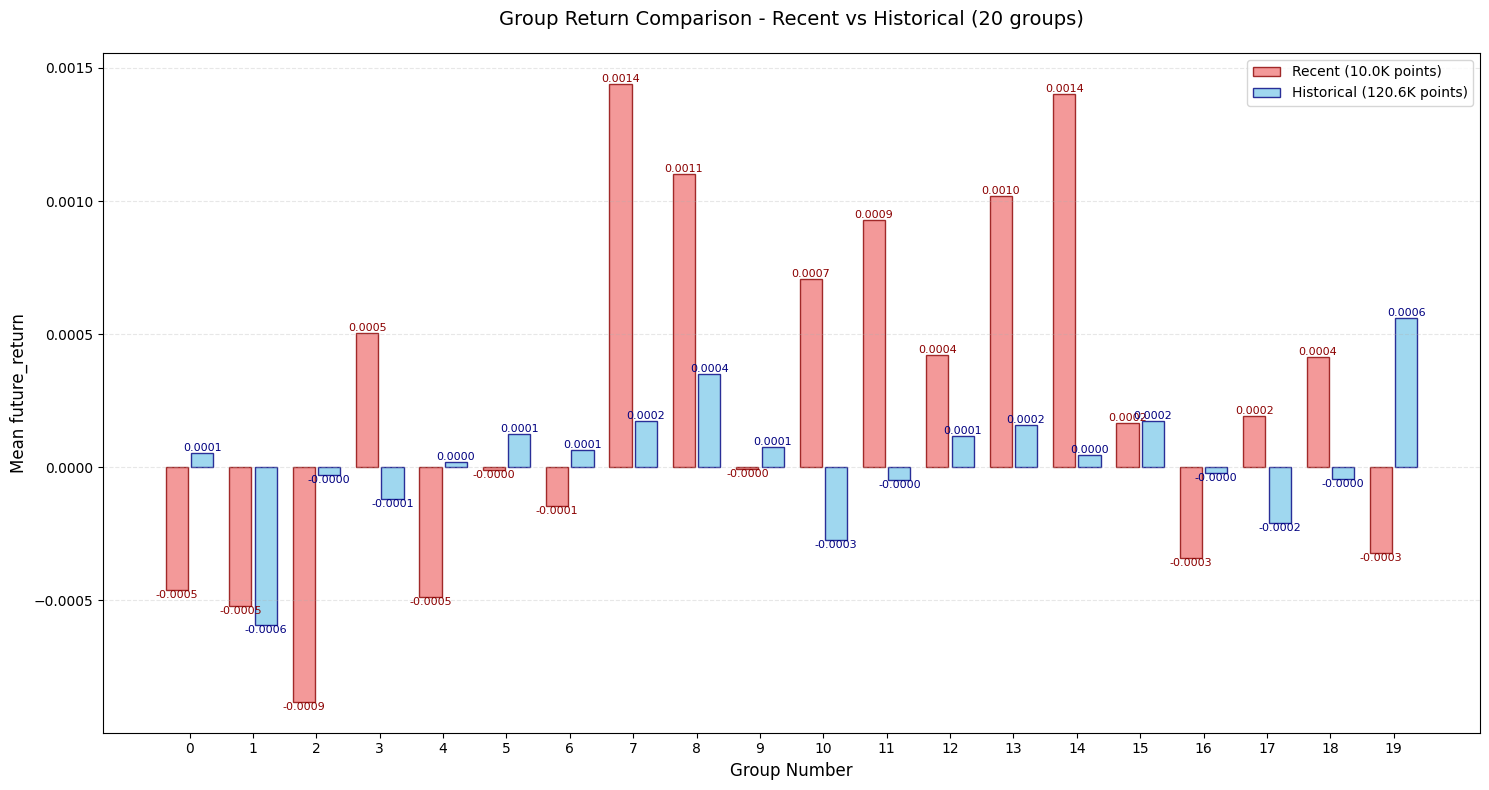

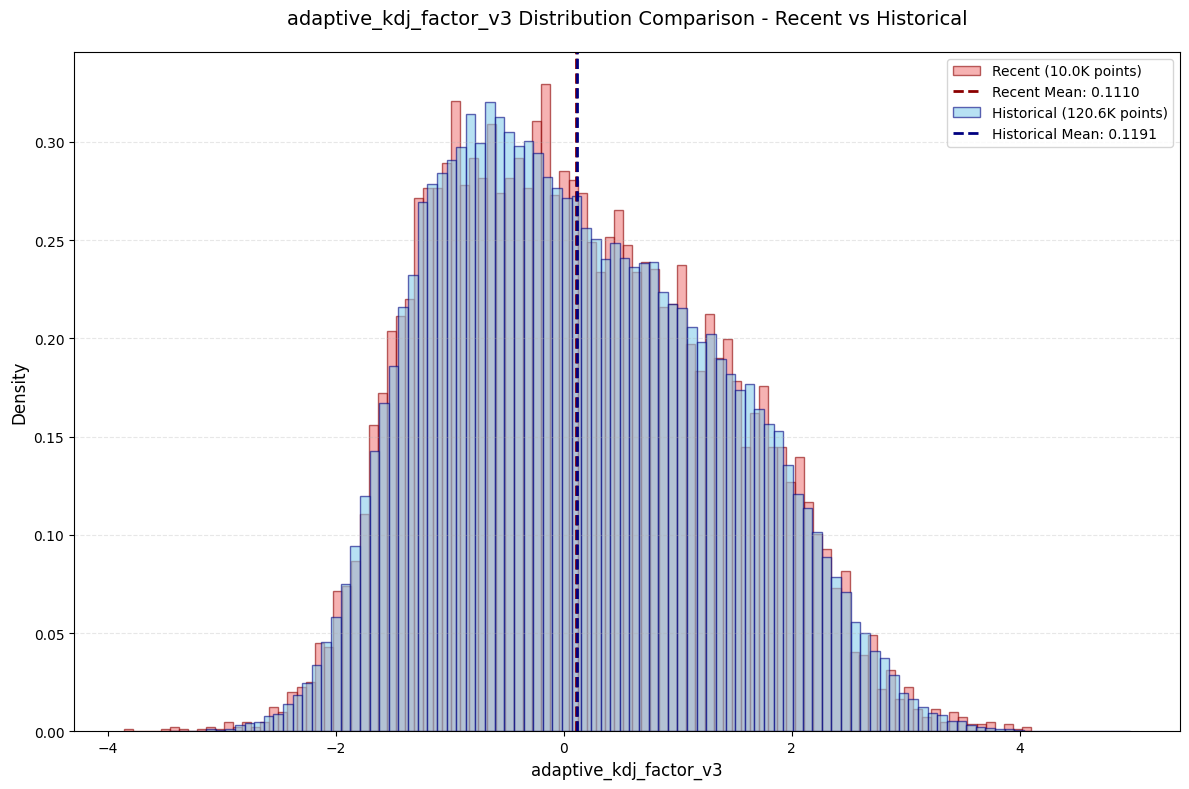

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [6]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)